## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
    

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5,0.7]
redice_lr_patient = [5,10]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr =  ReduceLROnPlateau(factor= reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
______________________________________________________________

49/49 [==============================] - 2s 43ms/step - loss: 1.2631 - accuracy: 0.5599 - val_loss: 1.4756 - val_accuracy: 0.4766
Epoch 14/25
49/49 [==============================] - 2s 41ms/step - loss: 1.2403 - accuracy: 0.5696 - val_loss: 1.4593 - val_accuracy: 0.4794
Epoch 15/25
49/49 [==============================] - 2s 41ms/step - loss: 1.2220 - accuracy: 0.5765 - val_loss: 1.4488 - val_accuracy: 0.4868
Epoch 16/25
49/49 [==============================] - 2s 42ms/step - loss: 1.2014 - accuracy: 0.5817 - val_loss: 1.4684 - val_accuracy: 0.4827
Epoch 17/25
49/49 [==============================] - 2s 41ms/step - loss: 1.1820 - accuracy: 0.5901 - val_loss: 1.4648 - val_accuracy: 0.4827
Epoch 18/25
49/49 [==============================] - 2s 42ms/step - loss: 1.1640 - accuracy: 0.5968 - val_loss: 1.4510 - val_accuracy: 0.4957
Epoch 19/25
49/49 [==============================] - 2s 41ms/step - loss: 1.1447 - accuracy: 0.6054 - val_loss: 1.4486 - val_accuracy: 0.4904
Epoch 20/25
49/49 

Epoch 1/25
49/49 [==============================] - 2s 42ms/step - loss: 2.2385 - accuracy: 0.2635 - val_loss: 2.1911 - val_accuracy: 0.1817
Epoch 2/25
49/49 [==============================] - 2s 38ms/step - loss: 1.7697 - accuracy: 0.3825 - val_loss: 2.0219 - val_accuracy: 0.2622
Epoch 3/25
49/49 [==============================] - 2s 38ms/step - loss: 1.6378 - accuracy: 0.4268 - val_loss: 1.8635 - val_accuracy: 0.3557
Epoch 4/25
49/49 [==============================] - 2s 38ms/step - loss: 1.5585 - accuracy: 0.4528 - val_loss: 1.7480 - val_accuracy: 0.3898
Epoch 5/25
49/49 [==============================] - 2s 39ms/step - loss: 1.5017 - accuracy: 0.4739 - val_loss: 1.6472 - val_accuracy: 0.4219
Epoch 6/25
49/49 [==============================] - 2s 38ms/step - loss: 1.4544 - accuracy: 0.4910 - val_loss: 1.5953 - val_accuracy: 0.4399
Epoch 7/25
49/49 [==============================] - 2s 38ms/step - loss: 1.4163 - accuracy: 0.5050 - val_loss: 1.5609 - val_accuracy: 0.4465
Epoch 8/25
49

49/49 [==============================] - 2s 38ms/step - loss: 0.4609 - accuracy: 0.8631 - val_loss: 1.5488 - val_accuracy: 0.5217
Epoch 22/25
49/49 [==============================] - 2s 41ms/step - loss: 0.4422 - accuracy: 0.8686 - val_loss: 1.5846 - val_accuracy: 0.5185
Epoch 23/25
49/49 [==============================] - 2s 39ms/step - loss: 0.4212 - accuracy: 0.8787 - val_loss: 1.6323 - val_accuracy: 0.5149
Epoch 24/25
49/49 [==============================] - ETA: 0s - loss: 0.4047 - accuracy: 0.8856
Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
49/49 [==============================] - 2s 41ms/step - loss: 0.4047 - accuracy: 0.8856 - val_loss: 1.6532 - val_accuracy: 0.5113
Epoch 25/25
49/49 [==============================] - 2s 41ms/step - loss: 0.3686 - accuracy: 0.9015 - val_loss: 1.5898 - val_accuracy: 0.5241
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
Model: "functional_11"
_________________________________________________________

Epoch 7/25
49/49 [==============================] - 2s 40ms/step - loss: 1.1623 - accuracy: 0.5978 - val_loss: 1.4486 - val_accuracy: 0.4843
Epoch 8/25
49/49 [==============================] - 2s 40ms/step - loss: 1.1219 - accuracy: 0.6135 - val_loss: 1.4962 - val_accuracy: 0.4716
Epoch 9/25
49/49 [==============================] - 2s 41ms/step - loss: 1.0865 - accuracy: 0.6278 - val_loss: 1.4719 - val_accuracy: 0.4769
Epoch 10/25
49/49 [==============================] - 2s 39ms/step - loss: 1.0531 - accuracy: 0.6390 - val_loss: 1.4325 - val_accuracy: 0.4978
Epoch 11/25
49/49 [==============================] - 2s 39ms/step - loss: 1.0231 - accuracy: 0.6502 - val_loss: 1.4027 - val_accuracy: 0.5150
Epoch 12/25
49/49 [==============================] - 2s 39ms/step - loss: 0.9934 - accuracy: 0.6622 - val_loss: 1.4316 - val_accuracy: 0.4979
Epoch 13/25
49/49 [==============================] - 2s 41ms/step - loss: 0.9684 - accuracy: 0.6707 - val_loss: 1.4648 - val_accuracy: 0.4881
Epoch 14/

Epoch 1/25
49/49 [==============================] - 2s 47ms/step - loss: 1.8323 - accuracy: 0.3701 - val_loss: 2.2274 - val_accuracy: 0.2212
Epoch 2/25
49/49 [==============================] - 2s 44ms/step - loss: 1.5299 - accuracy: 0.4597 - val_loss: 2.1301 - val_accuracy: 0.2746
Epoch 3/25
49/49 [==============================] - 2s 43ms/step - loss: 1.4165 - accuracy: 0.4986 - val_loss: 2.2729 - val_accuracy: 0.2577
Epoch 4/25
49/49 [==============================] - 2s 43ms/step - loss: 1.3348 - accuracy: 0.5254 - val_loss: 2.1002 - val_accuracy: 0.3067
Epoch 5/25
49/49 [==============================] - 2s 42ms/step - loss: 1.2710 - accuracy: 0.5519 - val_loss: 2.0957 - val_accuracy: 0.3303
Epoch 6/25
49/49 [==============================] - 2s 43ms/step - loss: 1.2227 - accuracy: 0.5689 - val_loss: 2.0176 - val_accuracy: 0.3427
Epoch 7/25
49/49 [==============================] - 2s 43ms/step - loss: 1.1763 - accuracy: 0.5862 - val_loss: 2.1138 - val_accuracy: 0.3129
Epoch 8/25
49

Epoch 20/25
49/49 [==============================] - 2s 42ms/step - loss: 0.7409 - accuracy: 0.7589 - val_loss: 1.4763 - val_accuracy: 0.4967
Epoch 21/25
49/49 [==============================] - 2s 42ms/step - loss: 0.7230 - accuracy: 0.7653 - val_loss: 1.5031 - val_accuracy: 0.5015
Epoch 22/25
49/49 [==============================] - 2s 42ms/step - loss: 0.7045 - accuracy: 0.7734 - val_loss: 1.4504 - val_accuracy: 0.5101
Epoch 23/25
49/49 [==============================] - 2s 43ms/step - loss: 0.6887 - accuracy: 0.7786 - val_loss: 1.4844 - val_accuracy: 0.4954
Epoch 24/25
49/49 [==============================] - 2s 42ms/step - loss: 0.6713 - accuracy: 0.7842 - val_loss: 1.5733 - val_accuracy: 0.4803
Epoch 25/25
49/49 [==============================] - 2s 43ms/step - loss: 0.6555 - accuracy: 0.7909 - val_loss: 1.5558 - val_accuracy: 0.4913
Numbers of exp: 10, reduce_factor: 0.70, reduce_patient: 5
Model: "functional_21"
_________________________________________________________________


49/49 [==============================] - 2s 43ms/step - loss: 1.7243 - accuracy: 0.3991 - val_loss: 1.8809 - val_accuracy: 0.3557
Epoch 4/25
49/49 [==============================] - 2s 42ms/step - loss: 1.6428 - accuracy: 0.4265 - val_loss: 1.7697 - val_accuracy: 0.3891
Epoch 5/25
49/49 [==============================] - 2s 43ms/step - loss: 1.5830 - accuracy: 0.4452 - val_loss: 1.6878 - val_accuracy: 0.4090
Epoch 6/25
49/49 [==============================] - 2s 46ms/step - loss: 1.5342 - accuracy: 0.4632 - val_loss: 1.6422 - val_accuracy: 0.4229
Epoch 7/25
49/49 [==============================] - 2s 44ms/step - loss: 1.4934 - accuracy: 0.4765 - val_loss: 1.6060 - val_accuracy: 0.4301
Epoch 8/25
49/49 [==============================] - 2s 44ms/step - loss: 1.4573 - accuracy: 0.4901 - val_loss: 1.5770 - val_accuracy: 0.4457
Epoch 9/25
49/49 [==============================] - 2s 44ms/step - loss: 1.4248 - accuracy: 0.5017 - val_loss: 1.5682 - val_accuracy: 0.4464
Epoch 10/25
49/49 [=====

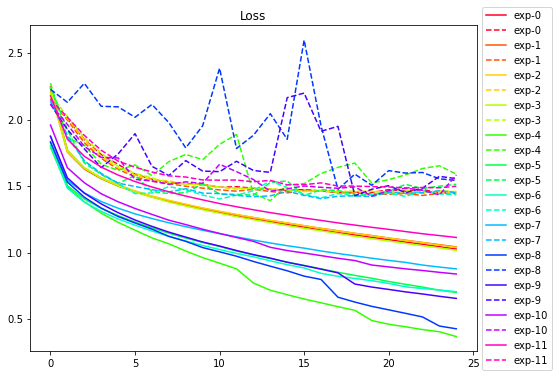

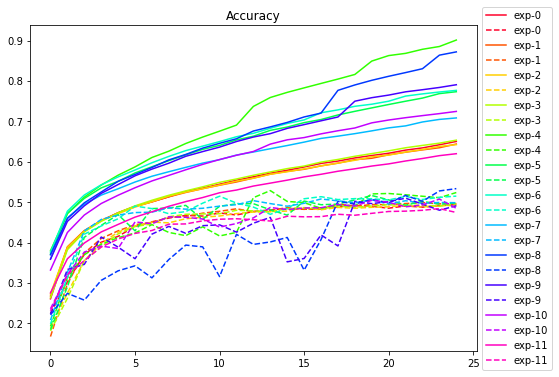

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()